<a href="https://colab.research.google.com/github/CasperHesp/GettingTheFeels/blob/main/IdeasWorthSpreading/culturalevolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def softmax(X):                                                                 ###converts log probabilities to probabilities
  norm = np.sum(np.exp(X)+10**-5)
  Y = (np.exp(X)+10**-5)/norm
  return Y

def softmax_dim2(X):                                                            ###converts matrix of log probabilities to matrix of probabilities
  norm = np.sum(np.exp(X)+10**-5,axis=0)
  Y = (np.exp(X)+10**-5)/norm
  return Y

def normalise(X):                                                               ###normalises a matrix of probabilities
  X= X/np.sum(X,0)
  return X


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:137: RuntimeWarning: divide by zero encountered in log


[[0.77136283 0.22863717]
 [0.22863717 0.77136283]]


<BarContainer object of 99 artists>

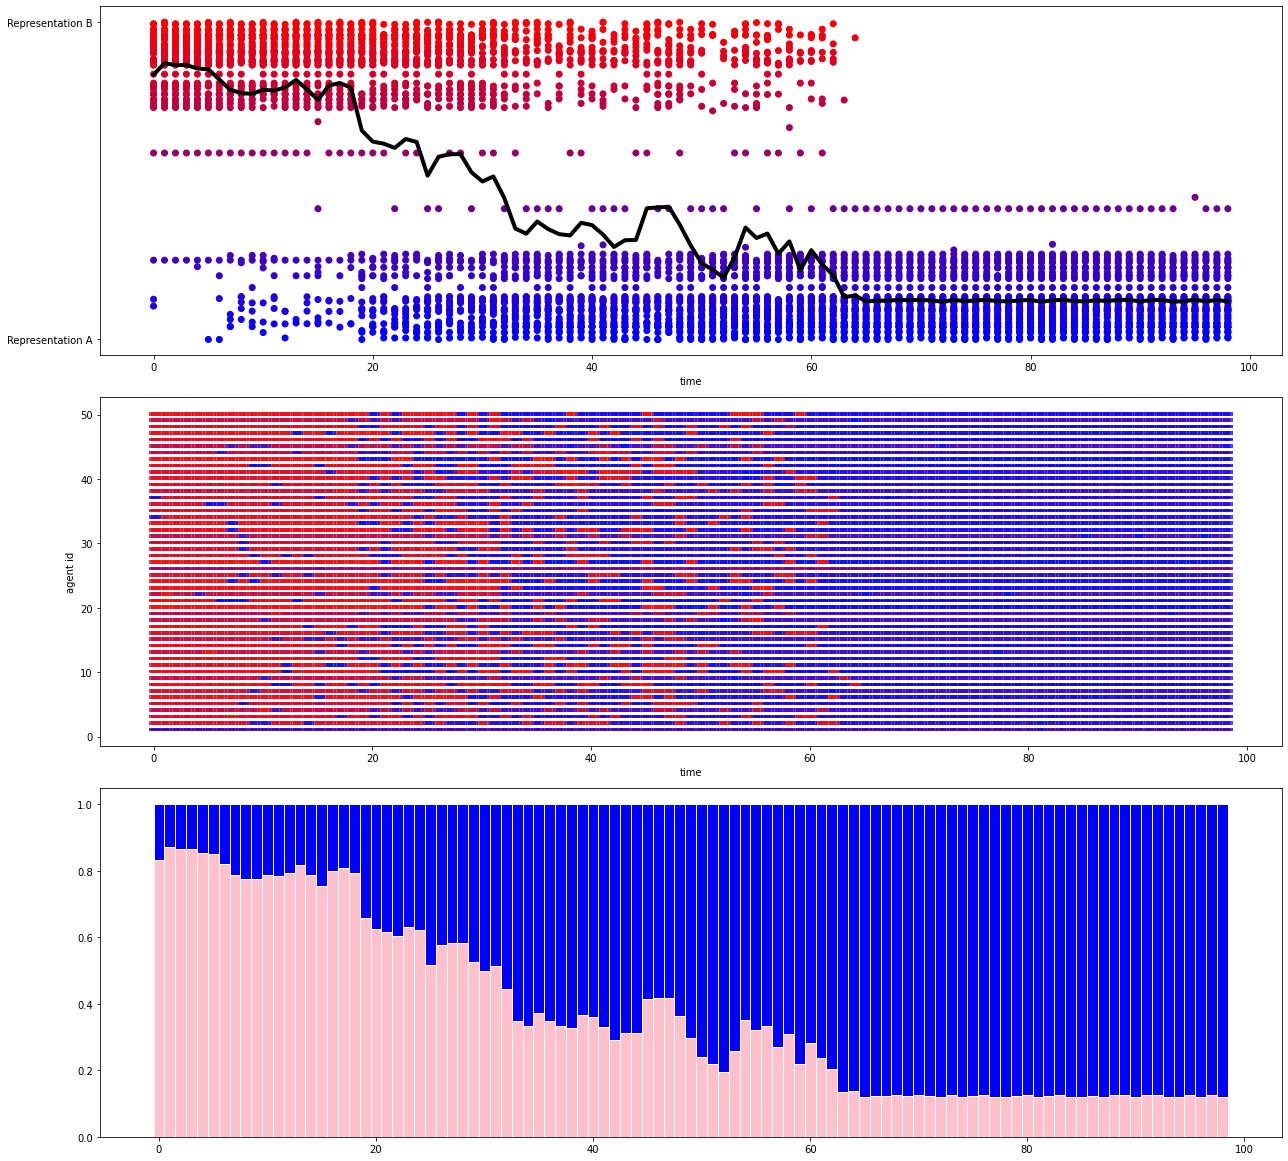

In [ ]:

K= 2                                                                            ## number of alternative beliefs
N= 50                                                                           ##number of agents
T= 100                                                                          ##number of time steps


##Tracking states over time- Making state for every agent in every time step 
X1 = np.zeros((K,N,N,T))                                                        ##beliefs of each agent about other agents' beliefs for each time step

#X1 = np.zeros((K,N,T))                                                         ##beliefs of agents for each time step

for i in range(N):
  if i < N/2:
    X1[:,i,:,0] = np.transpose(np.transpose(X1[:,i,:,0])+[1-10**-1,10**-1])     ## initialise beliefs about first half of agents
  else:
    X1[:,i,:,0] = 0.5 #np.transpose(np.transpose(X1[:,i,:,0])+[10**-1,1-10**-1])## initialise beliefs about second half of agents


#for i in range(N):
#  X1[:,0,i,0] = [10**-1,1-10**-1]       

for i in range(N):
  if i >0:
    X1[:,i,i,0] = [1-10**-4,10**-4]    ###initialise own beliefs of each agent 
  else:
     X1[:,i,i,1] = [10**-4,1-10**-4]                                            ## initialise agent 0 beliefs
O1 = np.zeros((2,N,T))                                                          ##satisfaction outcomes (high, low) of agents for each time step---- haven't put values here, these come in later

################################################################ MATRICES ################################################################

##Making E Matrix for each agent- Action priors
#F                                         ##reliance on baseline action prior  ##Q: correct me if i'm wrong but I feel like this gamma E is a redundent step as we could have simply made the matrix E with  existing  variability in it's indexes? 
E = np.zeros((K,N))                                                             ## baseline action prior already
E[:,1:]=np.transpose(np.transpose(E[:,1:])+[6.0,0.1])                           ###set all agents except agent 0
E[:,0]=[0.1,6.0]                                                                ###set agent 0


##Making A Matrix for each agent- Belief generates Satisfaction. 
gammaA1 = np.random.gamma(5.0,size=N)*6.0                                        ##sensitivity to evidence regarding belief states   ##Question: but this is sensitivity to which belief state? or are we just assuming sensitivity is the same for both?
gammaA2 = np.random.gamma(10.0,size=N)                                          ##sensitivity to evidence regarding satisfaction   ##same question, and also 1.why sesitivity so low? 2. what about none?   
A2 = np.zeros((2,K,N))                                                          ###likelihood of satisfaction (high/low) given belief (1 or 2)
for i in range(N): 
  if i != 0:                                                                          ##for the first agent onwards
    A2[:,0,i] = np.random.dirichlet((6,4))                                      ###status quo is (slightly) more likely to bring satisfaction in the general population 
    A2[:,1,i] = [0.5,0.5]                                                       ###new belief has unknown mapping (because the link between the belief and satisfaction has not been learned yet)
  else:                                                                              ###set rogue agent 0 
    A2[:,0,i] = [0,1]                                                           ### Complete dissatisfaction with old belief 
    A2[:,1,i] = [1,0]                                                           ### Complete satisfaction with new belief 


##Making B matrix for each agent - why is there action prior here? 
gammaB1 = 0.5*np.random.gamma(4.0,size=N)                                           ##inverse volatility of beliefs (B-matrix precision for beliefs X1) of each agent
gammaB2 = np.random.gamma(0.5,size=N)                                           ##Learning Habits

gammaB1[0] = 1

B0 = np.array([[0.75,0.25],[0.25,0.75]])                                        ## General transition matrix- All agents have a better probability of staying than switching. 
B1 = np.zeros((K,K,N))                                                          ##transition matrix for each agent's beliefs
B2 = np.zeros((K,K,N))                                                          ###transition matrix for each agent's baseline action prior
for i in range(N):  
  B1[:,:,i]=normalise(B0**gammaB1[i])                                           ##every matrix (for each agent)is just slightly different. 
  B2[:,:,i]=normalise(B0**gammaB2[i])                                           ##every matrix (for each agent)is just slightly different. 


##Making G matrix for each agent- how confident is every agent with their actions
gammaG = np.random.gamma(1.0,size=N)                                            ##action confidence of each agent    ##### Question: what is the point of generating random action confidenc here, if below we generate it from satisfaction level? 
gammaGm = [4.0,0.5]

gammaE = np.random.gamma(1.0,size=N)                                            ##action confidence of each agent    ##### Question: what is the point of generating random action confidenc here, if below we generate it from satisfaction level? 

Es = np.zeros((N,N)) ##social action prior (a list of N values for each of N agents)
gammaEs = 0.1*np.copy(gammaE)*np.random.normal(1,0.05) ### defaul reliance on habitual action (Es) concernling location (gammaEs correlates with gammaE)

################################################################ AGENTS MEETING ##################################################################################

##Birds of a feather- flock together: Making agents meet- with likelyhood of a meeting correlating with similarity of belief state between agents (people meet whoever is similar to them).
gammaGloc = np.random.gamma(6.0,size=N)     ## default reliance on action model (G1) concerning location (including risk + ambigui)

ppUi=np.zeros(2)
ppUj=np.zeros(2)

O1 = np.zeros((2,N,T)) 

A2C = np.zeros((2,2,N))
for i in range(N):
  if i<N/2:
    A2C[:,0,i] = np.random.dirichlet((6,4))  ### generating a population with relatively weak mapping of X2 -> C1 
  else:
    A2C[:,0,i] = np.random.dirichlet((999,1))  ### generating a population with relatively strong mapping of X2 -> C1 (conformity)


  A2C[:,1,i] = A2C[::-1,0,i]

Xmem = np.zeros((N,N)) ## memory of having visited an agent (yes/no)

store_confprior = []
store_confclaim = [] 

for t in range(T):                                                              ##loop through time steps
  for i in range(N):                                                            ##loop through agents
    #print(t,i)
    ##calculate KL divergence with other agents ##cohesive force (how close the agents belief is to other agents)
    #KL = np.sum(X1[:,i,i,t]*(np.log(X1[:,i,i,t]/np.transpose(X1[:,:,i,t]+10**-7)+10**-7)),axis=1) ## calculate divergence
    
    C1 = np.log(np.inner(A2C[:,:,i],X1[:,i,i,t])+10**-7)

    G1 = np.zeros(N)                                                            ###expected free energy of visiting each agent
    G1 += .1*np.sum(1.0-Xmem[:,i]) ###calculate total ambiguity left in the environment
    for j in range(N):                                                          ## calculting the risk involved in a particular selection,
      G1[j] = np.sum(X1[:,j,i,t]*(np.log(X1[:,j,i,t]+10**-7)-C1))               ###calculate risk associated with visiting agent j
      if Xmem[j,i]==0:
        G1[j] += -1*.1 ###calculating reduction in ambiguity associated with visiting agent j

    #print(KL)
    P = softmax(-1*gammaGloc[i]*G1+gammaEs[i]*Es[:,i])
    #P = softmax(-1*gammaS[i]*KL-1*gammaN[i]*(KL+10**-7)**-1+gammaEs[i]*Es[:,i])        ## ##transform to probability
    ### p meeting softmax([conformity bias]+[novelty bias]+[habitual bias])
    if len(P[np.isnan(P)])>0:
      print(P)
    j = np.random.choice(np.arange(N),p=P)                                    ##sample agent to meet, with probability of meeting going up with the cohesive force (PKL)
    Xmem[j,i] = 1
    Es[j,i] += 0.05


##Satisfaction and Confidence= the more satisfied an agent is, the more confident he is with his belief.  #### Question: but where does the other agent pick up on this? 
    O1[:,i,t] = np.inner(A2[:,:,i],X1[:,i,i,t])                                   ###generate satisfaction level agent i IN EVERY TIME STEP. for the satisfaction distribution of every agent in every time step, take how belief maps to satisfaction for that agent (A2) * their belief at each time step)
    O1[:,j,t] = np.inner(A2[:,:,j],X1[:,j,j,t])                                         ###generate satisfaction level agent j. 
    gammaG[i] = np.dot(gammaGm,O1[:,i,t])                                       ###generate action confidence for agent i from satisfaction, in every time step. 
    gammaG[j] = np.dot(gammaGm,O1[:,j,t])                                             ###generate action confidence for agent j from satisfaction


################################################################ CONVERSATION #########################################################################################


    ###### An agent makes a specific claim of belief 
    lnX1i = np.log(X1[:,i,i,t])                                                   ##the belief of agent i at time t      
    lnX1j = np.log(X1[:,j,j,t])                                                   ##the belief of agent j at time t 

    #lnX1ij = np.log(X1[:,i,j,t])                                                   ##the belief of agent j about agent i's belief at time t      
    #lnX1ji = np.log(X1[:,j,i,t])                                                   ##the belief of agent i about agent j's belief at time t 

    

    pUi = 12*softmax(gammaG[i]*np.log(X1[:,i,i,t]+10**-5) +gammaE[i]*E[:,i])         ###obtain probability of belief claim from agent i (what is the probability of )
    pUj = 12*softmax(gammaG[j]*np.log(X1[:,j,j,t]+10**-5) +gammaE[j]*E[:,j])         ###obtain probability of belief claim from agent j  #is't pU just the action prior? 




    if len(pUj[np.isnan(pUj)])>0 or len(pUi[np.isnan(pUj)])>0:
      print(t,i,j,pUi,pUj,np.log(X1[:,i,i,t]+10**-7),np.log(X1[:,j,j,t]+10**-7),E[:,i],E[:,j])

    ppUi[0] = np.random.beta(pUi[0],pUi[1])                                      ###pull from a beta distribuation so that sometimes one is more convincing and sometimes the other
    ppUi[1] = (1-ppUi[0])                                                        ### so this is the specific claim the agent makes, not a prrobability distibution. 
    
    ppUj[0] = np.random.beta(pUj[0],pUj[1])
    ppUj[1] = (1-ppUj[0])


    store_confprior.append(X1[0,i,i,t])
    store_confclaim.append(np.amax(pUi))
    store_confprior.append(X1[0,j,j,t])
    store_confclaim.append(np.amax(pUj))


    #ki = np.random.choice(np.arange(K),p=pUi)                                   ###selecting an action U from agent i
    #kj = np.random.choice(np.arange(K),p=pUj)                                   ###selecting an action U from agent j
    if ((j ==0) or (i==0)):                                                     ###if you meet agent 0, you observe k=1
        #print(i,t)
        ppUj=np.array([0.1,.9])                                                     ###not random anymore because it relies on 
        ppUi=np.array([0.1,.9])

    E[:,i] += 0.1*ppUi                                                              ##adapt baseline action prior for agent i  ##whatever claim you made, increaases the probility of claiming that again. 
    E[:,j] += 0.1*ppUj                                                            ##adapt baseline action prior for agent j

 

 ######the listening agent somewhat converges/synchs with what he heard           ###The convergence must be more suttle. 
    lnX1i += gammaA1[i]*ppUj                                                     ###Convergence: add claim of agent j as evidence for agent i to option k--- this is where the convergence of the belief of two agents happens. 
    
    lnX1j += gammaA1[j]*ppUi                                                     ###Convergence: add claim of agent i as evidence for agent j to option k

 ######Learning how new (and old) beliefs map on to satisfaction from satisfaction of other agent. 
    lnA2i = np.log(A2[:,:,i]+10**-7)                                            ###take log probability of A2i (Mapping between belief and satisfaction)
    lnA2j = np.log(A2[:,:,j]+10**-7)                                            ###take log probability of A2j (Mapping between belief and satisfaction)
    for k in range(K):
      lnA2i[:,k] += gammaA2[i]*np.log(O1[:,j,t])*ppUj[k]                         ### learning from observation of other person's satisfaction + their belief, about how belief maps on to satisfaction (this is where agents are able to learn how satisfaction maps on to belief 2, when they meet agent 0)
      lnA2j[:,k] += gammaA2[j]*np.log(O1[:,i,t])*ppUi[k]                         ### learning from observation of other person's satisfaction 

    A2[:,:,i] = softmax_dim2(lnA2i)                                             ###changing to probabiliities
    A2[:,:,j] = softmax_dim2(lnA2j)                                             ###changing to probabiliities

    X1[:,j,i,t] = ppUj ### agent i updates their beliefs about the beliefs of agent j
    X1[:,i,j,t] = ppUi ### agent j updates their beliefs about the beliefs of agent i

 ######This gives us the belief for the next time step
    if t<(T-1):                                                                
      X1[:,i,i,t+1] = np.inner(B1[:,:,i],softmax(lnX1i))
      X1[:,j,i,t+1] = np.inner(B1[:,:,i],ppUj)
                          
      X1[:,j,j,t+1] = np.inner(B1[:,:,j],softmax(lnX1j))
      X1[:,i,j,t+1] = np.inner(B1[:,:,i],ppUi)

      X1[:,i,i,t+1][X1[:,i,i,t+1]>(1-10**-5)]=1-10**-5
      X1[:,j,j,t+1][X1[:,j,j,t+1]>(1-10**-5)]=1-10**-5
      X1[:,i,i,t+1][X1[:,i,i,t+1]<10**-5]=10**-5
      X1[:,j,j,t+1][X1[:,j,j,t+1]<10**-5]=10**-5

      X1[:,i,j,t+1][X1[:,i,j,t+1]>(1-10**-5)]=1-10**-5
      X1[:,j,i,t+1][X1[:,j,i,t+1]>(1-10**-5)]=1-10**-5
      X1[:,i,j,t+1][X1[:,i,j,t+1]<10**-5]=10**-5
      X1[:,j,i,t+1][X1[:,j,i,t+1]<10**-5]=10**-5

  for i in range(N):
    E[:,i] = np.inner(B2[:,:,i],E[:,i])
    E[:,j] = np.inner(B2[:,:,j],E[:,j])  

store_confprior = np.array(store_confprior)
store_confclaim = np.array(store_confclaim)


###########################################################################################################
print(B2[:,:,1])

if 1:
  plt.figure(figsize=(18,16))
  plt.subplot(3,1,1)
  for i in range(N):
    C = np.zeros((T-1,3))
    C[:,0] = X1[0,i,i,1:]
    C[:,2] = X1[1,i,i,1:]
    plt.scatter(np.arange(T-1),X1[0,i,i,1:],label='agent %d' % i,c=C)
  #plt.legend()

  R = np.zeros(T-1)
  for i in range(N):
    R += X1[0,i,i,1:]*N**-1
  plt.plot(R,linewidth=4,color='black')
  #plt.ylim([,1])
  #plt.yscale('log')
  #print(B1[:,:,10])
  #plt.plot(gammaA1)
  #plt.plot(np.sum(O1[0,:,:],axis=0)/N, linewidth=4,color='black')
  plt.xlabel('time')
  plt.yticks([0,1],['Representation A','Representation B'])
  plt.tight_layout()

#print(kj)

if 1:
  plt.subplot(3,1,2)
  #plt.figure(figsize=(12,6))
  for i in range(N):
    C = np.zeros((T-1,3))
    C[:,0] = X1[0,i,i,1:]
    C[:,2] = X1[1,i,i,1:]
    plt.scatter(np.arange(T-1),np.ones(T-1)*(i+1)+0.25,label='Agent %d' % i,c=C,marker='_',s=100)
    plt.scatter(np.arange(T-1),np.ones(T-1)*(i+1),label='Agent %d' % i,c=C,marker='_',s=100)

    plt.scatter(np.arange(T-1)+.25,np.ones(T-1)*(i+1)+0.25,label='agent %d' % i,c=C,marker='_',s=100)
    plt.scatter(np.arange(T-1)+.25,np.ones(T-1)*(i+1),label='agent %d' % i,c=C,marker='_',s=100)
    #plt.scatter(np.arange(T-1)+0.5,np.ones(T-1)*(i+1),label='agent %d' % i,c=C,marker='_',s=100)
  plt.tight_layout()
  plt.ylabel('agent id')
  plt.xlabel('time')

plt.subplot(3,1,3)
r = np.arange(T-1)
barWidth=1.0
R = np.zeros(T-1)
for i in range(N):
  R += X1[0,i,i,1:]*N**-1
plt.bar(r, R, color='Pink', edgecolor='white', width=barWidth, label = 'very low')
plt.bar(r, 1-R, bottom=R, color='blue', edgecolor='white', width=barWidth, label = 'low')


Text(0.5, 0, 'prior belief')

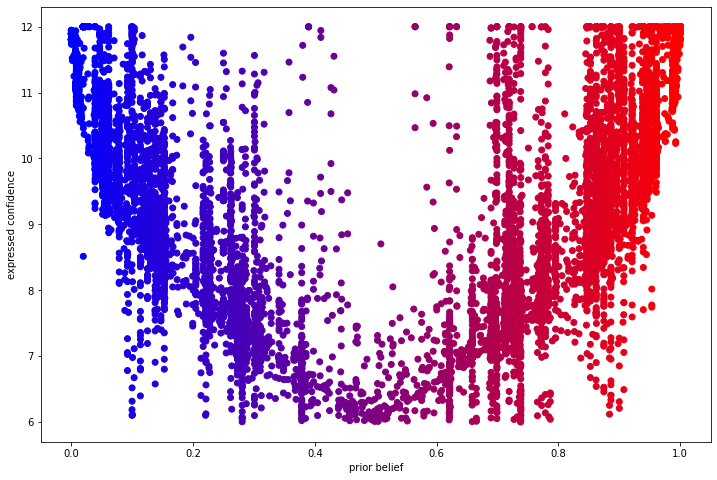

In [ ]:
plt.figure(figsize=(12,8))
#plt.subplot(2,1,1)
c_matrix = np.zeros((len(store_confprior),3))
c_matrix[:,0]=store_confprior
c_matrix[:,2]=1-store_confprior

plt.scatter(store_confprior,store_confclaim,color=c_matrix)
plt.ylabel('expressed confidence')
plt.xlabel('prior belief')

#plt.subplot(2,1,2)

#H,xedge,yedge=np.histogram2d(store_confprior,store_confclaim,bins=20)
#plt.imshow(H)

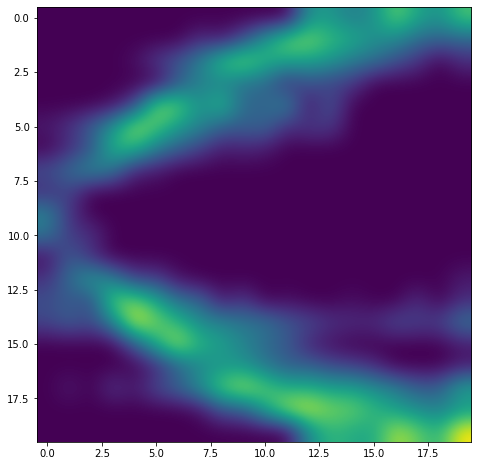

In [ ]:
plt.figure(figsize=(8,8))
H,xedge,yedge=np.histogram2d(store_confprior,store_confclaim,bins=20)
H[H<6]=6
plt.imshow(np.transpose(np.transpose(np.log(H))),interpolation='bicubic',cmap='viridis')

In [ ]:
np.random.dirichlet((6,4))

array([0.49231759, 0.50768241])

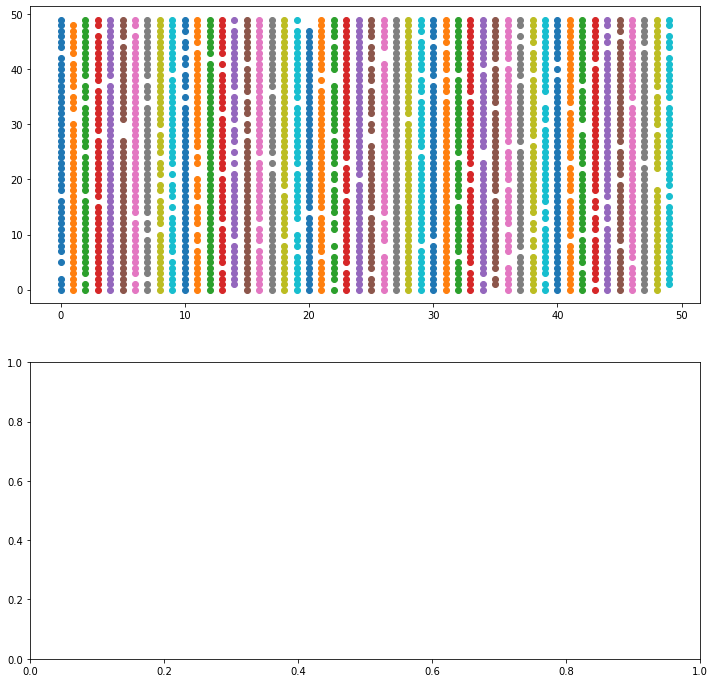

In [ ]:
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
for i in range(N):
  plt.scatter((np.ones(N)*i)[:][Xmem[:,i]==1], np.arange(N)[:][Xmem[:,i]==1])
plt.subplot(2,1,2)
#plt.imshow()

<BarContainer object of 99 artists>

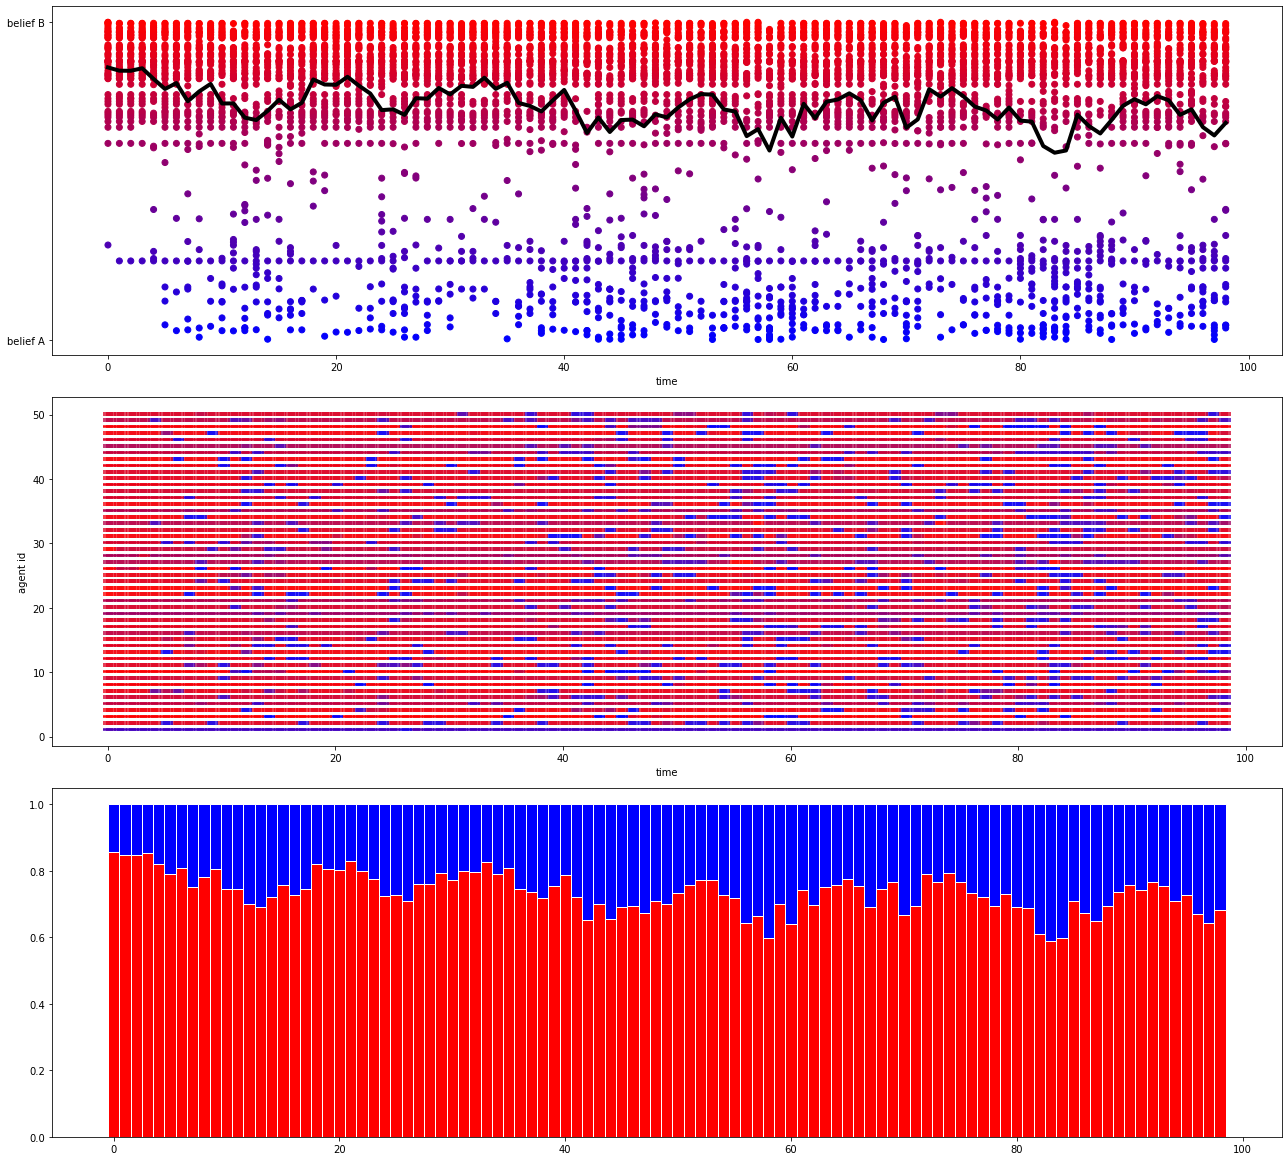

In [ ]:
if 1:
  plt.figure(figsize=(18,16))
  plt.subplot(3,1,1)
  for i in range(N):
    C = np.zeros((T-1,3))
    C[:,0] = X1[0,i,i,1:]
    C[:,2] = X1[1,i,i,1:]
    plt.scatter(np.arange(T-1),X1[0,i,i,1:],label='agent %d' % i,c=C)
  #plt.legend()

  R = np.zeros(T-1)
  for i in range(N):
    R += X1[0,i,i,1:]*N**-1
  plt.plot(R,linewidth=4,color='black')
  #plt.ylim([,1])
  #plt.yscale('log')
  #print(B1[:,:,10])
  #plt.plot(gammaA1)
  #plt.plot(np.sum(O1[0,:,:],axis=0)/N, linewidth=4,color='black')
  plt.xlabel('time')
  plt.yticks([0,1],['belief A','belief B'])
  plt.tight_layout()

#print(kj)

if 1:
  plt.subplot(3,1,2)
  #plt.figure(figsize=(12,6))
  for i in range(N):
    C = np.zeros((T-1,3))
    C[:,0] = X1[0,i,i,1:]
    C[:,2] = X1[1,i,i,1:]
    plt.scatter(np.arange(T-1),np.ones(T-1)*(i+1)+0.25,label='agent %d' % i,c=C,marker='_',s=100)
    plt.scatter(np.arange(T-1),np.ones(T-1)*(i+1),label='agent %d' % i,c=C,marker='_',s=100)

    plt.scatter(np.arange(T-1)+.25,np.ones(T-1)*(i+1)+0.25,label='agent %d' % i,c=C,marker='_',s=100)
    plt.scatter(np.arange(T-1)+.25,np.ones(T-1)*(i+1),label='agent %d' % i,c=C,marker='_',s=100)
    #plt.scatter(np.arange(T-1)+0.5,np.ones(T-1)*(i+1),label='agent %d' % i,c=C,marker='_',s=100)
  plt.tight_layout()
  plt.ylabel('agent id')
  plt.xlabel('time')

plt.subplot(3,1,3)
r = np.arange(T-1)
barWidth=1.0
R = np.zeros(T-1)
for i in range(N):
  R += X1[0,i,i,1:]*N**-1
plt.bar(r, R, color='red', edgecolor='white', width=barWidth, label = 'very low')
plt.bar(r, 1-R, bottom=R, color='blue', edgecolor='white', width=barWidth, label = 'low')

Text(0.5, 33.0, 'time')

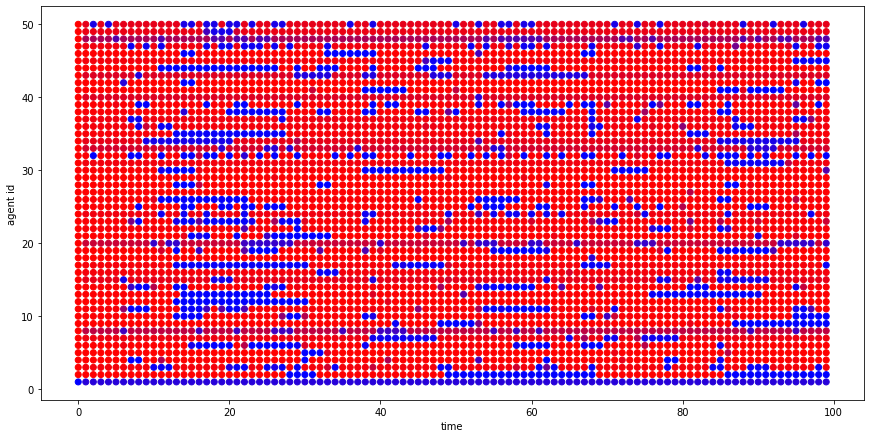

In [ ]:
plt.figure(figsize=(12,6))
for i in range(N):
  C = np.zeros((T,3))
  C[:,0] = X1[0,i,:]
  C[:,2] = X1[1,i,:]
  plt.scatter(np.arange(T),np.ones(T)*(i+1),label='agent %d' % i,c=C)
plt.tight_layout()
plt.ylabel('agent id')
plt.xlabel('time')



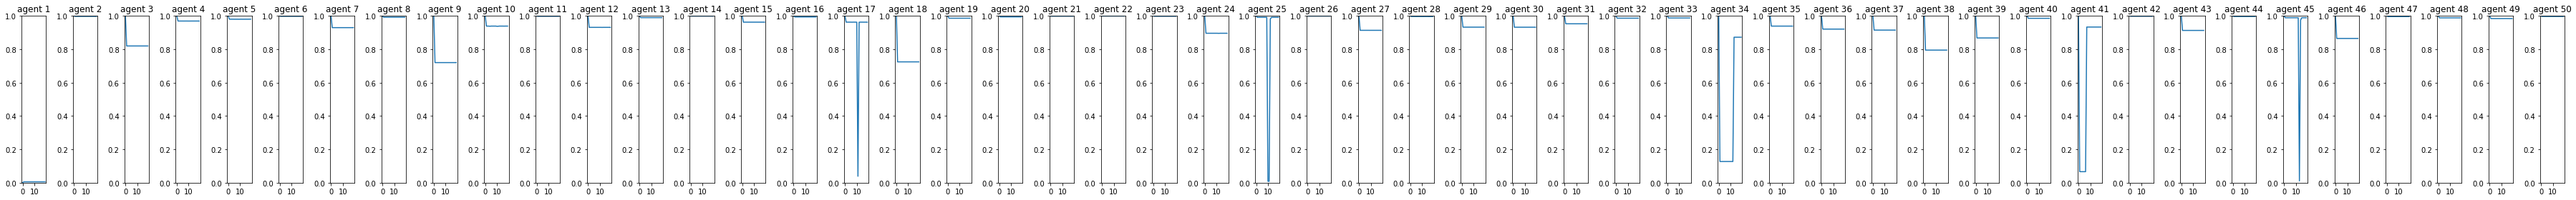

In [ ]:
plt.figure(figsize=(N,4))
for i in range(N):
  plt.subplot(1,N,i+1)
  plt.plot(np.arange(T),X1[0,i,:],label='agent %d' % i)
  plt.ylim([0,1])
  plt.title('agent %d' % (i+1))
#plt.legend()
#plt.plot(np.sum(X1[0,:,:],axis=0)/N,linewidth=4,color='black')

#plt.yscale('log')
#print(B1[:,:,10])
#plt.plot(gammaA1)
#plt.plot(np.sum(O1[0,:,:],axis=0)/N, linewidth=4,color='black')
plt.tight_layout()
#print(kj)

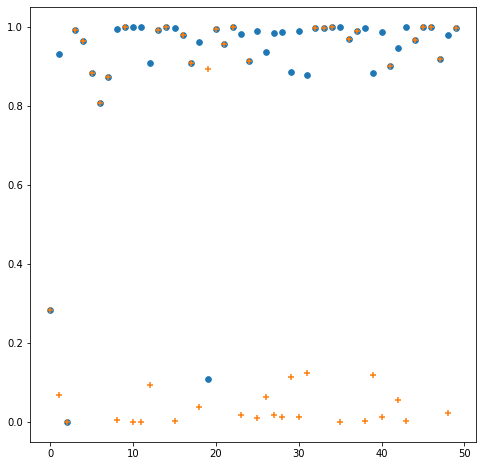

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,1,1)
plt.scatter(np.arange(N),X1[0,:,1],s=32)
#plt.subplot(2,1,2)
plt.scatter(np.arange(N),X1[0,:,-1],s=32,marker='+')

In [ ]:
E = np.zeros((K,N)) ## baseline action prior 
E[:,1:]=np.transpose(np.transpose(E[:,1:])+[60.0,1.0]) ###set all agents except agent 0------ before: isn't this actually excluding the 2nd agent and not the first one..?
E[:,0]=[1.0,60.0] ###set agent 0
print(E)

[[ 1. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60.
  60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60.
  60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60.]
 [60.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]]
